In [80]:
import pysal as ps  # requires PySAL version 1.14.  does not work with v2.x
import geopandas as gpd
import pandas as pd
import networkx as nx  # requires networkx version 2.2.  Does not work with v1.x 
from copy import deepcopy
import matplotlib
import fiona
from math import pi
from shapely.geometry import shape

# make sure you have the right PySAL and networkx versions
print('PySAL version:', ps.__version__)
print('networkx version:', nx.__version__)

PySAL version: 1.14.4
networkx version: 2.2


## Pre-processing
We used the election return shapefile published by the Minnesota Legislature.  Unfortunately, we discovered that this shapefile contained many topology errors.  We used ArcMap to clean up these topology errors.

Many Minnesota voting precincts are entirely contained within other precincts.  This is especially the case in Greater Minnesota, where smaller towns and cities are their own precincts, and the surrounding unincorporated township is another.  This proved a serious problem for ensuring contiguity of districts, so we also used ArcMap to disolve most of these enclave precincts.

## parameters:
**shapefile (str) -** path to a polygon shapefile with fields for d_votes, r_votes, and population by precinct<br>
**d_votes (str) -** name of the field in the shapefile that identifies the number of votes for the Democratic Party.  All field names have a 10 character limit.  Stick to that limit or Bad Things will happen<br>
**r_votes (str) -** name of the field in the shapefile that identifies the number of votes for the Republican Party<br>
**population (str) -** name of the field in the shapefile that identifies the population of the precinct<br>
**party (str) -** 'd' to gerrymander in favor of the Democratic Party.  'r' for the Republican Party<br>
**num_dist (int) -** number of districts to create<br>
**num_pack (int) -** number of districts to pack with voters of the disfavored party, defaults to 1.  0 packed districts means the algorithm will attempt to evenly distribute voters of each party among districts.  -1 means the algorithm will only attempt to evenly distribute the population among districts, without respect to the distribution of voters<br>

In [11]:
# given a shapefile showing votes by precinct, find statistically significant hotspots for 
# each party (HH for dems, LL for reps)
def hotspots(shapefile, d_votes, r_votes):
    
    #print(shapefile)
    
    # have pysal read the shapefile into a pandas dataframe
    data = ps.pdio.read_files(shapefile)
    
    # add a measure of vote % for one party. We're conly considering two parties, so the other party's 
    # vote % can be inferred
    #print(data.loc[0])
    
    for i in range(len(data)):
        data.loc[i, 'd_pct'] = (data.loc[i, d_votes]) / max((data.loc[i, r_votes] + data.loc[i, d_votes]), 1)  # prevent division by zero

    # use pysal.queen to determine precinct adjacencies.  Even though rook contiguity is required for
    # valid districts, queen is more appropriate for determining neighborhood clusters
    W = ps.queen_from_shapefile(shapefile)

    # call the Local Moran's I function from pandas for the DFL precentage of total votes
    moran = ps.Moran_Local(data.d_pct.values, W)
    
    # set sig equal to all of the precincts that with significant values < .05
    # these precincts are not randomly distributed
    sig = moran.p_sim < .05
    
    # the .q method gives the categories of each precinct.  1 means high DFL votes surrounded by other 
    # high DFL precincts, 3 means high republican vote precincts surrounded by other high Republican
    # precincts.  Multiplying by the T/F values in sig will return the category of each district if 
    # significant, 0 otherwise
    hotspots = moran.q * sig
    
    # convert the hotspots numpy array to a dictionary
    hotspots_dict = {i:hotspots[i] for i in range(len(hotspots))}
    
    return hotspots_dict
    

In [68]:
# given a polygon shapefile, convert it to a networkx contiguity graph with attribute values
# for each node corresponding to the shapefile attributes

def graph_from_shapefile(shapefile, d_votes, r_votes, population):

    # valid districts have rook contiguity between precincts.
    
    contig = ps.rook_from_shapefile(shapefile)

    # convert the PySAL contiguity object into a networkx graph
    
    G = nx.Graph()
    for i in contig:
        edge_list = [(i[0], neighbor) for neighbor in list(i[1].keys())]
        G.add_edges_from(edge_list)

    # add the FID to the graph as an attribute.  We need this because later we're going to change
    # the number of each node, but we can't lose the FID the node is associated with
    
    FID_values = {FID:FID for FID in G}
    nx.set_node_attributes(G, FID_values, name='FID')

    # we need add attribute information for d_votes, r_votes, and population from the shapefile to the graph
    # This can easily be genericized to cast any shapefile to graph
    
    attributes = ps.pdio.read_files(shapefile).loc[:, [d_votes, r_votes, population]]  # faster to use ps.pdio.read_files than gpd.read_file
    attribute_values = {i:dict(attributes.iloc[i]) for i in range(len(attributes))}  # gets dataframe values as a dictionary in a form that can be added to the graph
    nx.set_node_attributes(G, attribute_values)

    # add an attribute to the graph to represent the partisan advantage of the node, normalized by population
    
    partisan_values = {}
    for i in range(len(G)):
        partisanship = (G.nodes[i][d_votes] - G.nodes[i][r_votes]) / max(G.nodes[i][population], 1)
        partisan_values[i] = round(partisanship, 3)
    nx.set_node_attributes(G, partisan_values, name='Partisanship')

    # Our packing algorithm is prone to getting stuck on local maxima.  PySAL can determine
    # local Moran's I values for each precinct to identify large d-leaning clusters (High-High) and 
    # large r-leaning clusters (Low-Low).  We can add those codes to the graph as another attribute
    
    COType_values = hotspots(shapefile, d_votes, r_votes)
    
    nx.set_node_attributes(G, COType_values, name='COType')

    return G

In [69]:
# remove nodes from graph G either because they don't match the correct party cluster or because
# they are in a remove_list parameter
def remove_node(G, party=None, remove_list=None):
    G_subgraph = deepcopy(G)  

    if party == 'r':
        cluster_type = 1  # favoring r means packing dems
    if party == 'd':
        cluster_type = 3

    if remove_list == None:  # we're removing nodes based on party
        remove_list = [n for n in G if G.nodes[n]['COType'] != cluster_type]  
    G_subgraph.remove_nodes_from(remove_list)
    return G_subgraph

In [73]:
# pack the disfavored party into a small number of districts.  Calls itself rescursively to pack
# more than 1 district.
def pack(G, 
         d_votes, 
         r_votes, 
         population, 
         party, 
         num_dist, 
         num_pack=1, 
         district_array=[],
         target_size=0):


    if num_pack < 1:  # the base case
        return district_array, G
    num_pack -= 1

    # to start the packing algorithm, we want a subgraph with the most partisan precinct clusters
    # make a copy of G so we don't lose any information

    G_clusters = remove_node(G, party)



    # within the cluster subgraph, find the highest population contiguous cluster

    contig_clusters = list(nx.connected_components(G_clusters))
    if len(contig_clusters) == 1:
        biggest_cluster = contig_clusters[0]
    else:
        biggest_cluster = []
        biggest_cluster_pop = 0
        for cluster in contig_clusters:
            cluster_pop = sum([G_clusters.nodes[n][population] for n in cluster])
            if cluster_pop > biggest_cluster_pop:
                biggest_cluster_pop = cluster_pop
                biggest_cluster = cluster        

    # find the most partisan precinct inside the biggest cluster

    target_precincts = [(G_clusters.nodes[n]['Partisanship'], n) for n in biggest_cluster]
    target_precincts.sort()
    if party == 'r': # we finding the most d district to start packing, since we're favoring r
        starting_precinct = target_precincts[-1][1] 
    
    # republicans are much harder to pack, setting starting precincts to a corner of the state to 
    # make it easier
    if party == 'd':  
        if 933 in G.nodes:
            starting_precinct = 933
        elif 1549 in G.nodes:
            starting_precinct = 1549
        else: 
            starting_precinct = target_precincts[0][1]

    # Districts should have roughly even population, but the law does not require them to be exactly 
    # equal population. Within 10% is good enough.  In addition to packing the disfavored party's 
    # voters in a district, we can also make that district larger than average, diluting the 
    # disfavored party even more.  We're going to add some orphan districts later, so we can't go the 
    # full amount over, but 3% over equal size should be a good target

    if target_size == 0:
        total_pop = sum([G.nodes[n][population] for n in G])
        target_size = 1.03 * (total_pop / num_dist)  # 3% over equal population

    # initialize values with the starting precinct

    district_pop = G.nodes[starting_precinct][population]

    # all the neighbors of the starting precinct are available to choose the next precinct from
    # store them as a (partisanship, FID) tuple so we can sort by partisanship
    available = [(G.nodes[n]['Partisanship'], n) for n in list(G[starting_precinct])]
    
    # in the clean-up phase we're also going to want to sort the precincts inside the district
    # by partisanship, so we're storing them as the same (partisanship, FID) tuple
    district = [(G.nodes[starting_precinct]['Partisanship'], starting_precinct)]

    # pack the district:
    
    # initialize a new graph to hold the remaining precincts as we pack the district
    # we want a new graph so we don't lose any information from the original
    
    G_remaining = deepcopy(G)
    
    # remove the starting precinct
    G_remaining.remove_nodes_from([starting_precinct])
    
    
    while district_pop < target_size:
        # pick the precinct in the available list with the greatest partisan lean
        # remove it from the available list
        
        if party == 'r':
            available.sort(reverse=True)
        if party == 'd':
            available.sort()
        next_precinct = available.pop(0)[1]

        # add that precinct to the district
        district.append((G.nodes[next_precinct]['Partisanship'], next_precinct))

        # increase the district's population
        district_pop += G.nodes[next_precinct][population]
        
        # delete the node from the graph:
        G_remaining.remove_nodes_from([next_precinct])
        
        # add that precinct's neighbors to the available list, if they aren't in either the district 
        # or available list already
        for neighbor in list(G[next_precinct]):
            neighbor_tuple = (G.nodes[neighbor]['Partisanship'], neighbor)
            if neighbor_tuple not in available and neighbor_tuple not in district:
                available.append(neighbor_tuple)
        
        # adding the district might have created 1 or more groups of orphan precincts.  Add
        # those orphans to the district and remove them from G_remaining
        
            # this way of dealing with orphans doesn't work great, because it can add a huge chunk of 
            # orphans that make the district way too big.  This was a problem for packing Republicans, 
            # which was solved by specifying start precincts in the corners of the state
        
        while nx.is_connected(G_remaining) == False: 
            orphans = min(nx.connected_components(G_remaining), key=len)  # find the smallest groups of orphans first
            orphans_tuple = [(G.nodes[orphan]['Partisanship'], orphan) for orphan in orphans]
            district.extend(orphans_tuple)
            district_pop += sum([G.nodes[n][population] for n in orphans])
            G_remaining.remove_nodes_from(orphans)

    
    district = [FID for partisanship, FID in district]  # reduce the district to a list of just precinct FIDs
    
    # assign each precinct a district value of 'P'+ a number to differentiate the different
    # packed districts
    district_code = 'P'+str(num_pack)
    district_array.extend([(precinct, district_code) for precinct in district])

    if num_pack > 0:  # more districts to pack, so call the function again
        district_array, G_remaining = pack(G_remaining,
                                           d_votes, 
                                           r_votes, 
                                           population, 
                                           party, 
                                           num_dist, 
                                           num_pack, 
                                           district_array,
                                           target_size)
    
    return district_array, G_remaining

In [6]:
# this is code we wrote to try to solve the orphan problem with packing districts.  It does create
# districts without orphans, but it takes an incredibly long time to run (over 30 mins) because it 
# checks dozens of candidate precincts every iteration, creating a new subgraph for each of them.  It
# also results in extremely non-compact districts.  It was also only needed for Republicans because
# they are so spread out.  In the end, it was easier to just specify the starting districts if we
# wanted to pack Republicans.  We're keeping it in the notebook to document that this type of 
# solution doesn't work.

# check to make sure adding the candidate won't break the contiguity of the remaining precincts
        
        #for i in range(len(available)):
            #next_precinct_candidate = available[i][1]
            
            # make a subgraph to see if adding the candidate will result in non-contiguity
            #subgraph = G_remaining.subgraph([n for n in G_remaining.nodes if n != next_precinct_candidate])
            
            
            #if nx.is_connected(subgraph) == False:
                #print('orphans created')
                #while nx.is_connected(subgraph) == False: 
                    #print(len(list(nx.connected_components(subgraph))))
                    
                    # if the discontinuity creates more than 5 orphan precincts in the smallest group
                    # of orphans, move to the next candidate
                    #if len(min(nx.connected_components(subgraph), key=len)) > 5: 
                        #print('that is a lot of orphans, trying another precinct')
                        #break
                    #print('that is not so many orphans, adding them to the district')
                    
                    # otherwise, add the orphans to the district until contiguity is restored
                    #orphans = min(nx.connected_components(subgraph), key=len)  # find the smallest groups of orphans first
                    #orphans_tuple = [(G.nodes[orphan]['Partisanship'], orphan) for orphan in orphans]
                    #district.extend(orphans_tuple)
                    #district_pop += sum([G.nodes[n][population] for n in orphans])
                    #print('population after adding orphans:', district_pop)
                   #G_remaining.remove_nodes_from(orphans)
                #continue  
            #else:
                #print('no orphans')
                #next_precinct = available.pop(i)[1]
                #print('Adding', next_precinct, 'Population:', district_pop, 'Need:', target_size-district_pop)
                #break

In [62]:
# METIS  (http://glaros.dtc.umn.edu/gkhome/metis/metis/overview) will divide precincts in such a way 
# that maximizes compactness, ensures roughly equal districts and spreads each party's voters evenly 
# (i.e. will crack the districts).  But it needs a file in a very particular format.  Given a graph, 
# reformat it into a file that METIS can read.  
def graph_to_metis(G, d_votes, r_votes, population, num_dist, num_pack):
    
    with open('METIS_input.txt', 'w') as fh:
        
        # metis needs the number of nodes and the number of edges as a header.  
        # 010 is the code to tell METIS the nodes are weighted.  The '3' tells METIS
        # that we are passing it three weights for each node.  See page 9 of the METIS
        # manual for more information about input file formats

        
        if num_pack > -1:  
            fh.write(str(len(G.nodes))+' '+str(len(G.edges))+' 010 3\n')
        else:
            fh.write(str(len(G.nodes))+' '+str(len(G.edges))+' 010 1\n') # -1 signifies that METIS should not try to balance r_votes and d_votes (i.e. districts based only on population)

        # METIS needs nodes to be numbered as consecutive integers.  
        G_renumbered = nx.convert_node_labels_to_integers(G, 1)

        for n in G_renumbered:
            weight1 = int(G_renumbered.nodes[n][population])
            weight2 = int(G_renumbered.nodes[n][r_votes])
            weight3 = int(G_renumbered.nodes[n][d_votes])
            neighbors = ' '.join(list(str(neighbor) for neighbor in G_renumbered[n]))  # list of neighbors as a space delimited string

            # METIS expects to see the node weights first, then the neighbors.  1 node on each line
            if num_pack > -1:
                fh.write(str(weight1)+' '+str(weight2)+' '+str(weight3)+' '+neighbors+'\n')
            else:
                fh.write(str(weight1)+' '+neighbors+'\n')  
            
    # print out a METIS command to use with the METIS_input file
    if num_pack > -1:
        
        # ubvec indicates how much METIS should try to balance the weights.  This value indicates that
        # METIS should not try to let the population weight vary at all between subgraphs, but that the
        # two other weights can go up to 8% over an even distribution.  This is only a starting point,
        # and will need to be adjusted in METIS to produce a high quality partition.
        ubvec = '1 1.08 1.08'  
    else:
        ubvec = '1'
    print("METIS command line entry: gpmetis METIS_input.txt %s -contig -ubvec='%s' -ncuts=100" % (num_dist-(max(num_pack, 0)), ubvec))
    
    metis_output = 'METIS_input.txt.part.'+str(num_dist-(max(num_pack, 0)))  # the filename METIS will output given the command line code above
    return metis_output

In [52]:
# join the METIS output file to the original shapefile.  Print some statistics about the districts
def metis_to_gdf(metis_output, shapefile, d_votes, r_votes, population):
    # read the METIS output

    with open(metis_output, encoding='cp850') as fh:
        metis_output = fh.read()

    # METIS output includes the newline character, so striding through by 2 gives just the output values
    metis = [line for line in metis_output[::2]]

    # zip the METIS output with the FID's from the subgraph of the remaining precincts that weren't packed
    FID = [G_remainder.nodes[n]['FID'] for n in G_remainder]
    district_assignment = list(zip(FID, metis))

    # add the packed district list from above to the district_assignment and turn it into a dataframe
    district_assignment.extend(packed_district)
    district_frame = pd.DataFrame(district_assignment)

    # change the column names so we can merge it with the shapefile geodataframe
    district_frame = district_frame.rename(index=str, columns={0: 'FID', 1: 'District'})

    # join the METIS output dataframe to the original shapefile

    #shapefile = 'elec2016.shp'
    #d_votes = 'SUM_USPRSD'
    #r_votes = 'SUM_USPRSR'
    #population = 'SUM_USPRST'

    # join the district assignment dataframe to the original shapefile
    district_map = gpd.read_file(shapefile).loc[:, [d_votes, r_votes, population, 'geometry']]

    for i in range(len(district_map)):
        district_map.loc[i, 'FID'] = i

    district_map = district_map.merge(district_frame, on='FID')

    # generate summary statistics for the districts
    statistics = district_map.groupby('District').sum().loc[:, [d_votes, r_votes, population]]

    # calculate the vote percentage for the Democratic Party
    for index in statistics.index.values:
        statistics.loc[index, 'dem%'] = statistics.loc[index, d_votes] / (statistics.loc[index, d_votes] + statistics.loc[index, r_votes])

    # make sure the largest precinct is no more than 10% larger than the smallest
    validate = (max(statistics.loc[:, population]) / min(statistics.loc[:, population])) <= 1.1

    # calculate how many districts were won by the Democratic party
    d_wins = len([district for district in statistics.loc[:, 'dem%'] if district > .5])    


    # display the statistics
    print('Valid:', validate)
    print('Democratic Districts:', d_wins)
    display(statistics)
    
    return district_map
    

## Running the Analysis
With the functions defined, we can actually start getting some results

In [71]:
# obtain graph G from the input shapefile. You only need to do this once per shapefile
G = graph_from_shapefile('elec2016.shp',
                         'SUM_USPRSD',  # field names have 10 character limit.  Make sure you keep to it or Bad Things will happen
                         'SUM_USPRSR',
                         'SUM_USPRST')

In [74]:
# get a list of precincts in the packed district and a graph of the leftover districts
packed_district, G_remainder = pack(G,
                                    d_votes='SUM_USPRSD', 
                                    r_votes='SUM_USPRSR',
                                    population='SUM_USPRST',
                                    party='r',
                                    num_dist=8,
                                    district_array=[],  # weird bug where if this default is not explicitly assigned, district_array will assign every precinct to itself again if this function is run again.
                                    num_pack=1)

In [75]:
# creates an input file and a command line command to run in METIS.  Returns the filename that METIS
# will output.  See the METIS documentation for more information.
metis = graph_to_metis(G=G_remainder, 
                       d_votes='SUM_USPRSD',
                       r_votes='SUM_USPRSR',
                       population='SUM_USPRST',
                       num_dist=8,
                       num_pack=1)

METIS command line entry: gpmetis METIS_input.txt 7 -contig -ubvec='1 1.08 1.08' -ncuts=100


Now you'll need to input the graph file into METIS.  Things will be easier if you put the METIS application in the same folder as this notebook.  After you run the METIS analysis, you can continue to run the Python code in this notebook with the METIS output file.  An example METIS output file (METIS_input.txt.part.7) was included in the .zip archive with this notebook for testing

In [76]:
# join the METIS output to the original shapefile, ensure the districts have valid populations, 
# check how many districts were won by democrats, and display some summary statistics
district_map = metis_to_gdf(metis, 
                            shapefile='elec2016.shp', 
                            d_votes='SUM_USPRSD',
                            r_votes='SUM_USPRSR',
                            population='SUM_USPRST')

Valid: True
Democratic Districts: 1


,SUM_USPRSD,SUM_USPRSR,SUM_USPRST,dem%
District,,,,
0,163711.0,189592.0,385710.0,0.463373
1,141932.0,190380.0,361853.0,0.427105
2,163603.0,165737.0,361991.0,0.496760
3,163380.0,184411.0,380483.0,0.469765
4,163249.0,174999.0,370210.0,0.482631
5,132859.0,190725.0,354390.0,0.410586
6,163227.0,179186.0,376752.0,0.476696
P0,296162.0,51090.0,379522.0,0.852873


In [43]:
# save the dataframe as a shapefile
district_map.to_file('district_map.shp')

We used the above process to generate a several partitions.  We then disolved the precincts into their respective districts for display and further analysis.  This code is for map 18, which was a pro-Democrat gerrymander that resulted in Democrats winning 6 of the 8 House seats.  This code still needs to be functionalized so we can show all 18 maps we generated

,geometry,USPRSDFL,USPRSR,SUM_USPRST,FID
District,,,,,
0,"POLYGON ((490620.7122 4974882.8421, 490413.543...",205263.0,139418.0,377839.0,686663.0
1,"(POLYGON ((481486.3530999999 4977835.9541, 481...",184718.0,159206.0,377268.0,667365.0
2,(POLYGON ((349629.3946000002 5264533.610400001...,180980.0,162052.0,376800.0,1089310.0
3,"POLYGON ((505691.2893000003 4816314.931, 50408...",193555.0,149177.0,377198.0,907508.0
4,(POLYGON ((500178.8788000001 4963566.319700001...,190258.0,153995.0,377661.0,603416.0
5,(POLYGON ((438134.6990999999 4939196.900900001...,206778.0,136312.0,376082.0,626024.0
P0,"POLYGON ((479404.7600999996 5121380.9899, 4793...",120155.0,229929.0,378385.0,1776976.0
P1,"(POLYGON ((439063.6299999999 4939517.9702, 439...",104969.0,244261.0,379259.0,1124608.0


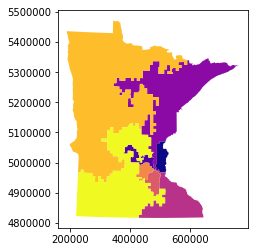

In [66]:
#After gerrymandering, the data has 8 districts. 
#We use Geopandas library to dissolve by district field. And create a new ESRI Shapefile.
map1 = gpd.read_file('district maps\district_map18\district_map18.shp') #reads shapefile
map1=map1.rename(index=str, columns={'SUM_USPRSR':'USPRSR', 'SUM_USPRSD':'USPRSDFL'}) #changes field names to have the same field names as other files have.
mapdiss = map1.dissolve(by='District',aggfunc='sum')
#mapdiss.to_file(filename=r'C:\Users\Meric Birol\Documents\district maps\dissolved\district_map18_diss.shp', driver='ESRI Shapefile')
mapdiss.plot(cmap='plasma')
mapdiss.head(8)

With dissolved districts, we can calculate the effeciency gap for each map

In [79]:
#Efficiency gap is being used for measuting Gerrymandering quality. Wasted votes are bases of the function. 

shapeFiles= [
            "district maps\dissolved/district_map1_diss.shp",
            "district maps\dissolved/district_map2_diss.shp",
            "district maps\dissolved/district_map3_diss.shp",
            "district maps\dissolved/district_map4_diss.shp",
            "district maps\dissolved/district_map5_diss.shp",
            "district maps\dissolved/district_map6_diss.shp",
            "district maps\dissolved/district_map7_diss.shp",
            "district maps\dissolved/district_map8_diss.shp",
            "district maps\dissolved/district_map9_diss.shp",
            "district maps\dissolved/district_map10_diss.shp",
            "district maps\dissolved/district_map11_diss.shp",
            "district maps\dissolved/district_map12_diss.shp",
            "district maps\dissolved/district_map13_diss.shp",
            "district maps\dissolved/district_map14_diss.shp",
            "district maps\dissolved/district_map15_diss.shp",
            "district maps\dissolved/district_map16_diss.shp",
            "district maps\dissolved/district_map17_diss.shp",
            "district maps\dissolved/district_map18_diss.shp",
            ]
MapNumber=0

for i in shapeFiles: #iterates through every item in the list
    fh=fiona.open(i,'r') #opens a shapefile at a time and loops through
    TotalWastedDemocrat=0
    TotalWastedRep=0
    TotalVotes=0
    MapNumber+=1
    print('Map:', MapNumber) #prints map number
    for f in fh:
        repVotes = f['properties']['USPRSR'] #get the republican votes
        demVotes = f['properties']['USPRSDFL'] #get the democrat votes
        totVotes = repVotes + demVotes #total votes by precints of Democrat and Republican Party
        TotalVotes=TotalVotes+totVotes #overall total votes (Republican+Democrat)
        if repVotes > demVotes: #if republican won
            wastedRVotes = int(( (repVotes - demVotes)/2) - 1) #wasted republican votes
            wastedDVotes = demVotes #wasted democrat votes
        elif demVotes > repVotes: #if democrat won
            wastedDVotes = int(( (demVotes - repVotes)/2) - 1) #wasted democrat votes
            wastedRVotes = repVotes #wasted republican votes
        TotalWastedDemocrat=TotalWastedDemocrat+wastedDVotes # total wasted votes by democrats
        TotalWastedRep=TotalWastedRep+wastedRVotes #total wasted votes by republicans
    fh.close # Close the file
    effGap=((TotalWastedDemocrat - TotalWastedRep)/TotalVotes)*100 #overall efficiency gap (percentage)
    if TotalWastedDemocrat>TotalWastedRep:
        print('Efficiency gap is in favor of Republicans')
    else:
        print('Efficiency gap is in favor of Democrats')
    print('%',effGap)

Map: 1
Efficiency gap is in favor of Republicans
% 26.511214029399998
Map: 2
Efficiency gap is in favor of Republicans
% 26.511214029399998
Map: 3
Efficiency gap is in favor of Republicans
% 27.136669842615476
Map: 4
Efficiency gap is in favor of Republicans
% 26.615133855440444
Map: 5
Efficiency gap is in favor of Republicans
% 26.511214029399998
Map: 6
Efficiency gap is in favor of Republicans
% 26.648879863466483
Map: 7
Efficiency gap is in favor of Republicans
% 26.955350232162107
Map: 8
Efficiency gap is in favor of Republicans
% 26.955350232162107
Map: 9
Efficiency gap is in favor of Republicans
% 25.238438267526135
Map: 10
Efficiency gap is in favor of Republicans
% 27.37196087156331
Map: 11
Efficiency gap is in favor of Republicans
% 0.07666215481778561
Map: 12
Efficiency gap is in favor of Republicans
% 1.7302464799486883
Map: 13
Efficiency gap is in favor of Republicans
% 14.23474408532302
Map: 14
Efficiency gap is in favor of Republicans
% 38.66260770973368
Map: 15
Efficienc

And we can calculate the compactness of each district

In [82]:
shapeFiles= [
            "district maps\dissolved/district_map1_diss.shp",
            "district maps\dissolved/district_map2_diss.shp",
            "district maps\dissolved/district_map3_diss.shp",
            "district maps\dissolved/district_map4_diss.shp",
            "district maps\dissolved/district_map5_diss.shp",
            "district maps\dissolved/district_map6_diss.shp",
            "district maps\dissolved/district_map7_diss.shp",
            "district maps\dissolved/district_map8_diss.shp",
            "district maps\dissolved/district_map9_diss.shp",
            "district maps\dissolved/district_map10_diss.shp",
            "district maps\dissolved/district_map11_diss.shp",
            "district maps\dissolved/district_map12_diss.shp",
            "district maps\dissolved/district_map13_diss.shp",
            "district maps\dissolved/district_map14_diss.shp",
            "district maps\dissolved/district_map15_diss.shp",
            "district maps\dissolved/district_map16_diss.shp",
            "district maps\dissolved/district_map17_diss.shp",
            "district maps\dissolved/district_map18_diss.shp",
            ]

mapNumber = 1
for shapeFile in shapeFiles: 
    print ("Map", mapNumber)
    fh = fiona.open(shapeFile, 'r')
    
    def compactness(area, perimeter):
        perimeterCircleArea = (perimeter ** 2) / (4 * pi) 
        #finds the area of a circle whose circumference is the same as the district's perimeter length
        ratio =   area / perimeterCircleArea
        #final ratio of the actual area of the district compared to the computed area from the perimeter
        return (ratio)

    compactnessSum = 0 #aggregates the compactnesses of each district in order to be divided for average compactness
    districtNumber = 0 

    for f in fh:
        shp_geom = shape(f['geometry']) #loads shape into shapely
        per = shp_geom.length #perimeter of polygon is found by length function in shapely
        area = shp_geom.area #area of the district
        compactnessSum += compactness(area, per) 
        districtNumber += 1 
        print ("District", districtNumber, ":", compactness(area, per)) #prints district with corresponding compactness

    overallCompactness = compactnessSum / 8

    print ("Average compactness: ", overallCompactness, "\n") #finds average compactness of map's districts
    mapNumber += 1 
    fh.close

Map 1
District 1 : 0.24202941404754358
District 2 : 0.21747042003212183
District 3 : 0.3179254698685731
District 4 : 0.3074885332410475
District 5 : 0.24373910734944265
District 6 : 0.25991010283328086
District 7 : 0.41115728410066177
District 8 : 0.22830882836846136
Average compactness:  0.27850364498014163 

Map 2
District 1 : 0.3179254698685731
District 2 : 0.21747042003212183
District 3 : 0.24202941404754358
District 4 : 0.3074885332410475
District 5 : 0.24373910734944265
District 6 : 0.41115728410066177
District 7 : 0.25991010283328086
District 8 : 0.22830882836846136
Average compactness:  0.2785036449801416 

Map 3
District 1 : 0.19772545889424578
District 2 : 0.35766748668247966
District 3 : 0.48629579568739745
District 4 : 0.3465675597640149
District 5 : 0.14039937811092726
District 6 : 0.23661943162099797
District 7 : 0.2424974238871458
District 8 : 0.22830882836846136
Average compactness:  0.27951017037695874 

Map 4
District 1 : 0.25406480592062924
District 2 : 0.24910791519